# Simple example of math. model with SciPy and power system sizing

Inspiration drawn from [this site](http://apmonitor.com/che263/index.php/Main/PythonOptimization). 

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

Pre začiatok budeme uvažovať jednoduchý príklad. Máme domácnosť s nejakou danou spotrebou a chceme zistiť, aký veľký dieselový generátor budeme potrebovať, aby sme vedeli vykriť jej spotrebu.

Rozhodovacie premenné teda budú maximálny výkon generátora a jeho aktuálny výkon v čase $t$. Obmedzenia budú rozsah aktuálneho výkonu (50% až 100%) a asi aj rozsah maximálneho výkonu generátora. Cieľová funkcia, ktorú budem minimalizovať je _Loss of power supply probability_, ktorú som našiel v [tomto článku](http://www.sciencedirect.com/science/article/pii/S1364032115000696). Hovorí o spoľahlivosť systému, resp. o percentuálnej šanci, že systém nebude generovať dostatok energie.

Najprv si vygenerujem totálne hračkárske dáta o spotrebe:

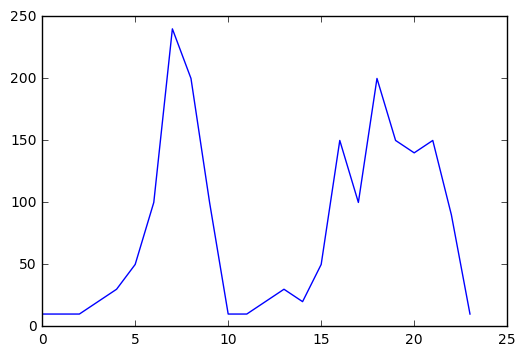

In [2]:
demands = np.array([10,10,10,20,30,50,100,240,200,100,10,10,20,30,20,50,150,100,200,150,140,150,90,10])
plt.plot(demands)

Teraz zadefinujem cieľovú stratovú funkciu. Tá berie ako argument vektor $x$, ktorý má v našom prípade 25 zložiek:
- prvá je maximálny výkon generátora
- druhá je percento určujúce aktuálny výkon generátora v čase $t$ (týchto úsekov je 24)

$de$ je pomocná funkcia, ktorá nám vyráta nedodanú energiu.

In [3]:
def de(generated, demanded):
    diff = generated - demanded
    diff[diff > 0] = 0
    return np.abs(diff)

# x[0] je maximálny výkon generátora
# x[1:25] je aktuálny výkon
def cost_function(x):
    return sum(de(x[0]*x[1:], demands))/sum(demands)

In [4]:
max_gen_power_bound  = (0,300)
curr_gen_power_bound = (0.5,0.9)
bnds = (max_gen_power_bound,*[curr_gen_power_bound,]*24)

initial_guess = np.array([100, *[0.9]*24])

# keby som chcel zadefinovat este nejake constrains, vyzeralo by to nejak takto:
#
# def constraint1(x):
#     return x[0]*x[1]*x[2]*x[3]-25
#
# def constraint2(x):
#     return sum(x**2) - 40
#
# con1 = {'type': 'ineq', 'fun': constraint1}
# con2 = {'type': 'eq',   'fun': constraint2}
# cons = ([con1, con2])
#
# minimize by sme potom zavolali s dodatocnym parametrom constraints=cons

solution = minimize(cost_function, initial_guess, method='SLSQP', bounds=bnds)

In [5]:
solution

     fun: 0.0
     jac: array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
 message: 'Optimization terminated successfully.'
    nfev: 270
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([ 298.72870385,    0.9       ,    0.9       ,    0.9       ,
          0.9       ,    0.9       ,    0.9       ,    0.5       ,
          0.9       ,    0.9       ,    0.5       ,    0.9       ,
          0.9       ,    0.9       ,    0.9       ,    0.9       ,
          0.9       ,    0.76156248,    0.5       ,    0.9       ,
          0.76156247,    0.76156248,    0.76156248,    0.9       ,    0.9       ])

Teraz si vykreslíme výsledok do grafu: krivku vygenerovanej energie a krivku spotreby:

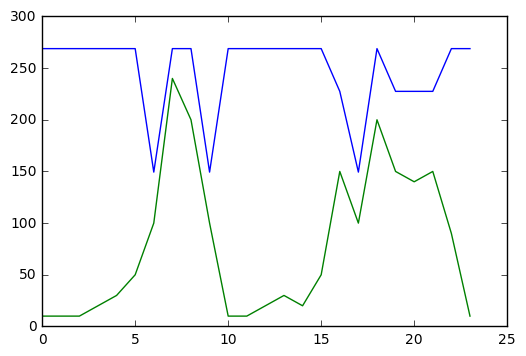

In [6]:
fig, ax = plt.subplots(1,1)
ax.plot(solution.x[0] * solution.x[1:])
ax.plot(demands)

Vzhľadom na to, že tam nejako nezohľadňujem cenu prevádzky generátora, tzn. môže byť vykúrený celú dobu na sto percent, je logické že nejaky curtail sa tam diať nebude. Treba teraz vykoumať, ako zohľadniť aj toto.